In [1]:
import psycopg2
import arcpy
import arcgis
import pandas as pd
import numpy as np
import datetime
import requests
#import geopandas
#import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
import pyodbc
import os
import warnings
import subprocess
import sys

In [2]:
#data source link

# MN temperature data in 2023
temperature_url = r"https://mesonet.agron.iastate.edu/api/1/daily.geojson?network=MN_RWIS&year=2023"

# MN Land Cover data in 2019
landcover_path = r"E:\coursework\ARCGIS2\LAB2\DATA\tif_biota_landcover_nlcd_mn_2019\NLCD_2019_Land_Cover.tif"

# MN 30m DEM 
elevation_path = r"E:\coursework\ARCGIS2\LAB2\DATA\fgdb_elev_30m_digital_elevation_model\elev_30m_digital_elevation_model.gdb/digital_elevation_model_30m"

#BDSB
stinkbug_path = r"E:\coursework\ARCGIS2\LAB2\DATA\stinkbug.csv"

# Output FGDB Path
out_local = r"E:\coursework\ARCGIS2\LAB2\LAB2.gdb" 


# Temperature (geojson)

In [8]:
#request and pull data via url
temperature_response = requests.get(temperature_url)

temperature_json = temperature_response.json()["features"]

#with open("E:\coursework\ARCGIS2\LAB2\DATA", 'w') as temperature_file:
#    json.dump(temperature_json, temperature_file, indent=4)

#define a fuction to extract data
def ExtractData(data,col,jasonfield):
    data[col] = data[jasonfield].apply(lambda x: dict(x)[col])

#transform geojason as dataframe
temperature_rawdf = pd.DataFrame.from_records(temperature_json)

#property info
temperature_col = ["id", "date", "name", "max_tmpf", "min_tmpf"]

for col_name in temperature_col:
    ExtractData(temperature_rawdf,col_name,"properties")

#location info
temperature_rawdf['x'] = temperature_rawdf["geometry"].apply(lambda x: dict(x)["coordinates"][0])
temperature_rawdf['y'] = temperature_rawdf["geometry"].apply(lambda x: dict(x)["coordinates"][1])

temperature_df = temperature_rawdf[["id", "date", "name", "max_tmpf", "min_tmpf",'x','y']].copy()

#missing values (temperature and location)
temperature_df = temperature_df.dropna(subset=["max_tmpf", "min_tmpf","x", "y"])
temperature_df["date"] = temperature_df["date"].astype('datetime64[ns]')
temperature_df["month"] = pd.DatetimeIndex(temperature_df["date"]).month

#bounding box
temperature_df =temperature_df[(temperature_df["x"] > -97.239) & (temperature_df["x"] < -89.492) &
                              (temperature_df["y"] > 43.499) & (temperature_df["y"] < 49.384)]

#outliers (mean+-3*std by station id AND month)
temperature_df = temperature_df[(temperature_df['min_tmpf']<=temperature_df['max_tmpf'])]

m = (temperature_df.groupby(['id','month'])['min_tmpf'].
     transform(lambda s: s.between(s.mean() - 3 * s.std(), s.mean() + 3 * s.std())))

temperature_df = temperature_df[m]

m = (temperature_df.groupby(['id','month'])['max_tmpf'].
     transform(lambda s: s.between(s.mean() - 3 * s.std(), s.mean() + 3 * s.std())))

temperature_df = temperature_df[m]

'''
fig = sns.displot(temperature_df,x='min_tmpf',kind='kde')
#fig = fig.get_figure()
plt.savefig(r'E:\coursework\ARCGIS2\LAB2\DATA\fig.png',dpi=400)
'''

"\nfig = sns.displot(temperature_df,x='min_tmpf',kind='kde')\n#fig = fig.get_figure()\nplt.savefig(r'E:\\coursework\\ARCGIS2\\LAB2\\DATA\x0cig.png',dpi=400)\n"

In [9]:
temperature_df

,id,date,name,max_tmpf,min_tmpf,x,y,month
0,MN001,2023-01-01,Twin Lakes I-35 Mile Post 1,37.040024,20.660011,-93.354057,43.508331,1
1,MN002,2023-01-01,Silver Lake TH 7 Mile Post 1,26.780000,17.599989,-94.119100,44.906800,1
2,MN003,2023-01-01,Little Chicago I-35 Mile Post 70,33.440020,18.140022,-93.292427,44.478500,1
3,MN004,2023-01-01,Rush City I-35 Mile Post 157,33.080000,21.380000,-92.992752,45.642921,1
4,MN005,2023-01-01,Rutledge I-35 Mile Post 198,31.819979,23.899988,-92.838562,46.212570,1
...,...,...,...,...,...,...,...,...
12011,MN158,2023-03-21,U.S.75 - Canby - MP 84.0 MN US MNDOT,16.880000,16.699990,-96.276932,44.674171,3
12012,MN159,2023-03-21,U.S.12 - Atwater - MP 85.4 MN US MNDOT,22.280000,21.560010,-94.811760,45.139050,3
12013,MN160,2023-03-21,U.S.14 - Florence - MP 21.2 MN US MNDOT,18.680000,18.680000,-96.046341,44.240311,3
12014,MN161,2023-03-21,U.S.12 - Delano - MP 140.4 MN US MNDOT,24.619978,24.440022,-93.766068,45.035450,3


# Land Cover (Raster) [rasterio]

In [99]:
#read data
raster_data = rasterio.open(landcover_path)

# Plot raster data (visual inspection)
plt.imshow(raster_data.read(1), cmap='viridis')
plt.title('Land Cover Raster')
plt.colorbar()
plt.show()

#get raster information
#coordinate system
with raster_data as src:
    raster_crs = src.crs

    print("Raster CRS:", raster_crs)

#cell size
with raster_data as src1:
    # Get the cell size (resolution) from the transform object
    cell_size_x = src1.transform[0]
    cell_size_y = -src1.transform[4]

# Print the cell size
print(f"Cell size (X): {cell_size_x} units")
print(f"Cell size (Y): {cell_size_y} units")

# Check if the data is categorical or not
# Conver the raster to numpy array
land_cover_array = arcpy.RasterToNumPyArray(landcover_path)

# Calculate the unique values in an array
unique_values = np.unique(land_cover_array)

# Set a threshold for the number of unique values to consider a raster categorical
threshold = 100

if len(unique_values) <= threshold:
    print("The land cover GeoTIFF is likely categorical.")
else:
    print("The land cover GeoTIFF is not categorical.")

# In this approach, we first convert the raster to a NumPy array
# then calculate the number of unique values in the array. 
# If the number of unique values is below a certain threshold (e.g., 100), 
# we consider the raster to be categorical. This is not a definitive method, 
# as the threshold value is arbitrary and could vary depending on your specific dataset. 

#check if raster is within bounding box
bounding_box = (132660, 4774410, 791819, 5491608)

with raster_data as src:
    raster_bbox = src.bounds
    
# Check if the raster is within the bounding box
    is_within_bbox = (
        raster_bbox.left >= bounding_box[0] and
        raster_bbox.bottom >= bounding_box[1] and
        raster_bbox.right <= bounding_box[2] and
        raster_bbox.top <= bounding_box[3]
    )

# Print the result
if is_within_bbox:
    print("The raster is within the bounding box.")
else:
    print("The raster is not within the bounding box.")
    
#bounding box
arcpy.management.Clip(landcover_path, "132660 4774410 791819 5491608", os.path.join(out_local, "landcover_clip"));

#missing value
# Check for null values
null_values = arcpy.management.GetRasterProperties(landcover_path, "ANYNODATA").getOutput(0)
if null_values == "1":
        print("Null values exist.")
else:
        print("Null values do not exist.")

Raster CRS: PROJCS["NAD_1983_UTM_Zone_15N",GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-93.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]
Cell size (X): 30.0 units
Cell size (Y): 30.0 units
The land cover GeoTIFF is likely categorical.
The raster is not within the bounding box.
Null values exist.


# DEM (raster) [arcpy]

In [101]:
#read data
elevation_data = arcpy.Raster(elevation_path)

# Plot raster data (visual inspection)
arcpy.ia.Render(elevation_data,colormap = 'viridis')

#get raster information
#coordinate system
crs = arcpy.Describe(elevation_path).spatialReference
print("Raster CRS:", crs.name)

#cell size
cell_size_x = float(arcpy.management.GetRasterProperties(elevation_path, "CELLSIZEX").getOutput(0))
cell_size_y = float(arcpy.management.GetRasterProperties(elevation_path, "CELLSIZEY").getOutput(0))

# Print the cell size
print(f"Cell size (X): {cell_size_x} units")
print(f"Cell size (Y): {cell_size_y} units")

# Check if the data is categorical or not
# Conver the raster to numpy array
elevation_array = arcpy.RasterToNumPyArray(elevation_path)

# Calculate  the unique values in an array
unique_values = np.unique(elevation_array)

# Set a threshold for the number of unique values to consider a raster categorical
threshold = 100

if len(unique_values) <= threshold:
    print("The land cover GeoTIFF is likely categorical.")
else:
    print("The land cover GeoTIFF is not categorical.")

#check if raster is within bounding box
bounding_box = (132660, 4774410, 791819, 5491608)

# Check if the raster is within the bounding box
is_within_bbox = (
    float(arcpy.management.GetRasterProperties(elevation_path, "LEFT").getOutput(0)) >= bounding_box[0] and
    float(arcpy.management.GetRasterProperties(elevation_path, "BOTTOM").getOutput(0)) >= bounding_box[1] and
    float(arcpy.management.GetRasterProperties(elevation_path, "RIGHT").getOutput(0)) <= bounding_box[2] and
    float(arcpy.management.GetRasterProperties(elevation_path, "TOP").getOutput(0)) <= bounding_box[3])

# Print the result
if is_within_bbox:
    print("The raster is within the bounding box.")
else:
    print("The raster is not within the bounding box.")

#missing value
# Check for null values
null_values = arcpy.management.GetRasterProperties(elevation_path, "ANYNODATA").getOutput(0)
if null_values == "1":
        print("Null values exist.")
else:
        print("Null values do not exist.")
        
        
#remove outlier
def find_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

elevation_array_flatten = elevation_array[~np.isnan(elevation_array)]

# Find outliers using the IQR method
lower_bound, upper_bound = find_outliers_iqr(elevation_array_flatten)
    
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
print(f"Number of unique values in raster: {len(np.unique(elevation_array_flatten))}")

# Create a mask for outliers
outlier_mask = np.logical_or(elevation_array < lower_bound, elevation_array > upper_bound)

# Get the row and column indices of the outliers
row_indices, col_indices = np.where(outlier_mask)

# Print the outlier pixel values and their indices
outliers_found = False
for row, col in zip(row_indices, col_indices):
    print(f"Outlier pixel value: {elevation_array[row, col]}, Row: {row}, Column: {col}")
    outliers_found = True

if not outliers_found:
    print("No outliers found in the raster.")

Raster CRS: NAD_1983_UTM_Zone_15N
Cell size (X): 30.0 units
Cell size (Y): 30.0 units
The land cover GeoTIFF is not categorical.
The raster is within the bounding box.
Null values exist.
Lower bound: -1870.5, Upper bound: 3117.5
Number of unique values in raster: 1509
No outliers found in the raster.


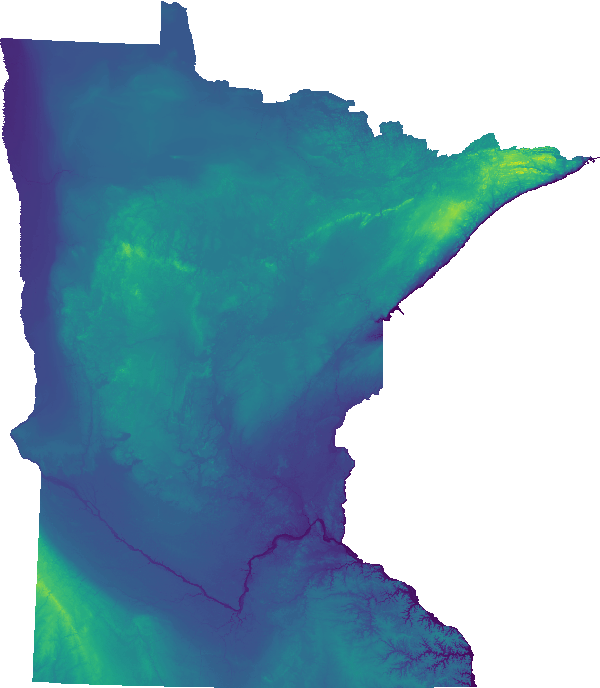

In [102]:
arcpy.ia.Render(elevation_data,colormap = 'viridis')

# Stinkbug (csv)

In [3]:
#get data and data cleaning
stinkbug_df = pd.read_csv(stinkbug_path, encoding = 'unicode_escape')
stinkbug_df = stinkbug_df[["objectid", "ObsDate", "Location", "Latitude", "Longitude", "Verified"]].copy()

#get valid data and remove missing data
stinkbug_df = stinkbug_df[stinkbug_df['Verified']=='Verified']
stinkbug_df = stinkbug_df.dropna(subset=["Latitude", "Longitude"])

# Filter where Location Contains 'Minnesota' and using bounding box
stinkbug_df = stinkbug_df[(stinkbug_df["Longitude"] > -97.239) & (stinkbug_df["Longitude"] < -89.492) &
                              (stinkbug_df["Latitude"] > 43.499) & (stinkbug_df["Latitude"] < 49.384)]
stinkbug_df = stinkbug_df[stinkbug_df["Location"].str.contains("Minnesota")]

# Convert DateTime Data Types and get 2023 data
stinkbug_df["ObsDate"] = stinkbug_df["ObsDate"].astype('datetime64[ns]')
stinkbug_df['ObsMonth'] = pd.DatetimeIndex(stinkbug_df["ObsDate"]).month
stinkbug_df = stinkbug_df[pd.DatetimeIndex(stinkbug_df["ObsDate"]).year==2023]



<string>:2: DtypeWarning: Columns (15,17,23,26,27,30,31,32,33,34,35,38,39,40,41,42,45,47,49,51,53,54,55,57,62,63,66,69,70,71,72,73,74,78) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
stinkbug_df

,objectid,ObsDate,Location,Latitude,Longitude,Verified,ObsMonth
95134,11289205,2023-01-03,"""Blue Earth, Minnesota, United States""",44.14337,-93.98741,Verified,1
95135,11289213,2023-01-03,"""Hennepin, Minnesota, United States""",44.86869,-93.32327,Verified,1
95136,11289214,2023-01-03,"""Anoka, Minnesota, United States""",45.18831,-93.23139,Verified,1
95137,11289216,2023-01-03,"""Olmsted, Minnesota, United States""",44.04444,-92.48130,Verified,1
95161,11299584,2023-01-27,"""Olmsted, Minnesota, United States""",44.02851,-92.44966,Verified,1
...,...,...,...,...,...,...,...
95482,11307475,2023-03-03,"""Ramsey, Minnesota, United States""",44.99755,-93.16011,Verified,3
95483,11307476,2023-03-03,"""Winona, Minnesota, United States""",44.05332,-91.66679,Verified,3
95484,11307477,2023-03-03,"""Dakota, Minnesota, United States""",44.91894,-93.07810,Verified,3
95485,11307478,2023-03-03,"""Ramsey, Minnesota, United States""",44.93541,-93.14974,Verified,3


# Export to local GDB

In [105]:
# Convert temperature from DF to SEDF
temperature_df = arcgis.GeoAccessor.from_xy(temperature_df, "x", "y")

# Convert temperature from SEDF to FC
temperature_df.spatial.to_featureclass(location=os.path.join(out_local, "temperature_df"))

# Export Elevation to Local GDB
arcpy.conversion.RasterToGeodatabase(elevation_path, out_local)

# Convert BMSB from DF to SEDF
stinkbug_df = arcgis.GeoAccessor.from_xy(stinkbug_df, "Longitude", "Latitude")

# Convert BMSB from SEDF to FC
stinkbug_df.spatial.to_featureclass(location=os.path.join(out_local, "stinkbug_df"))

'E:\\coursework\\ARCGIS2\\LAB2\\LAB2.gdb\\stinkbug_df'

# Export to PostGIS

In [10]:
#temperature table
# Set up the PostgreSQL connection
connection = psycopg2.connect(host = '35.193.80.209',
                             database = 'Lab2',
                             user = 'postgres',
                             password = 'zyx11457')

# Set the name of the new table in the PostgreSQL database
output_table = "temperature_df"

# Use psycopg2 to create the table in the PostgreSQL database
cursor = connection.cursor()
cursor.execute(f"CREATE TABLE {output_table} (id varchar, date date, name text, max_tmpf double precision, min_tmpf double precision, x double precision, y double precision, month integer)")

# Use psycopg2 to copy the data from the Geodatabase table to the PostgreSQL table
for index, row in temperature_df.iterrows():
    cursor.execute(f"INSERT INTO {output_table} (id, date, name, max_tmpf, min_tmpf, x, y, month) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)", (row['id'], row['date'],row['name'], row['max_tmpf'], row['min_tmpf'], row['x'], row['y'], row['month']))

# Commit the changes to the PostgreSQL database
connection.commit()

# Close the PostgreSQL connection and cursor
cursor.close()
connection.close()

In [7]:
#stinkbug table
# Set up the PostgreSQL connection
connection = psycopg2.connect(host = '35.193.80.209',
                             database = 'Lab2',
                             user = 'postgres',
                             password = 'zyx11457')

# Set the name of the new table in the PostgreSQL database
output_table = "stinkbug_df"

# Use psycopg2 to create the table in the PostgreSQL database
cursor = connection.cursor()
cursor.execute(f"CREATE TABLE {output_table} (objectid varchar, ObsDate	 date, Location text, Latitude double precision, Longitude double precision, ObsMonth integer)")

# Use psycopg2 to copy the data from the Geodatabase table to the PostgreSQL table
for index, row in stinkbug_df.iterrows():
    cursor.execute(f"INSERT INTO {output_table} (objectid, ObsDate, Location, Latitude, Longitude, ObsMonth) VALUES (%s, %s, %s, %s, %s, %s)", (row['objectid'], row['ObsDate'],row['Location'], row['Latitude'], row['Longitude'], row['ObsMonth']))

# Commit the changes to the PostgreSQL database
connection.commit()

# Close the PostgreSQL connection and cursor
cursor.close()
connection.close()

In [ ]:
#landcover raster
landcover_path = "E:\coursework\ARCGIS2\LAB2\LAB2.gdb\landcover_clip"
temp_path = "E:\coursework\ARCGIS2\LAB2\DATA"
landcover_data = arcpy.Raster(landcover_path)

arcpy.RasterToOtherFormat_conversion(landcover_data, temp_path, 'TIFF')


In [ ]:
# Set the input raster file path and output PostGIS raster table name
input_raster = r"E:\coursework\ARCGIS2\LAB2\DATA\landcover_clip.tif"
raster_table = "landcover_table"

# Define the connection parameters for the target PostGIS database
pg_host = '35.193.80.209'
pg_port = 5432
pg_dbname = 'Lab2'
pg_user = 'postgres'
pg_password = 'zyx11457'

# Set the SRID for the raster data
srid = "4269"

# Set the PATH environment variable for the subprocess
postgis_bin_path = r"D:\PostgreSQL\15\bin"  # Replace <version> with your PostgreSQL version
os.environ["PATH"] = postgis_bin_path + os.pathsep + os.environ["PATH"]

# Set the PGPASSWORD environment variable for the raster2pgsql command
os.environ["PGPASSWORD"] = pg_password

# Build the raster2pgsql command with the tiling option
raster2pgsql_cmd = f"raster2pgsql -s {srid} -I -C -M -t 30x30 {input_raster} -F {raster_table} | psql -h {pg_host} -p {pg_port} -U {pg_user} -d {pg_dbname} -W {pg_password}"

# Execute the raster2pgsql command
process = subprocess.run(raster2pgsql_cmd, shell=True, stderr=subprocess.PIPE, text=True)

if process.returncode != 0:
    print("An error occurred while running the raster2pgsql command:")
    print(process.stderr)
    sys.exit(1)

print("Raster data successfully imported to PostGIS.")



In [ ]:
os.remove(input_raster)


In [ ]:
#dem raster
elevation_path = "E:\coursework\ARCGIS2\LAB2\LAB2.gdb\digital_elevation_model_30m"
temp_path = "E:\coursework\ARCGIS2\LAB2\DATA"
elevation_data = arcpy.Raster(elevation_path)

arcpy.RasterToOtherFormat_conversion(elevation_data, temp_path, 'TIFF')

# Set the input raster file path and output PostGIS raster table name
input_raster = r"E:\coursework\ARCGIS2\LAB2\DATA\digital_elevation_model_30m.tif"
raster_table = "elevation_table"

# Define the connection parameters for the target PostGIS database
pg_host = '35.193.80.209'
pg_port = 5432
pg_dbname = 'Lab2'
pg_user = 'postgres'
pg_password = 'zyx11457'

# Set the SRID for the raster data
srid = "4269"

# Set the PATH environment variable for the subprocess
postgis_bin_path = r"D:\PostgreSQL\15\bin"  # Replace <version> with your PostgreSQL version
os.environ["PATH"] = postgis_bin_path + os.pathsep + os.environ["PATH"]

# Set the PGPASSWORD environment variable for the raster2pgsql command
os.environ["PGPASSWORD"] = pg_password

# Build the raster2pgsql command with the tiling option
raster2pgsql_cmd = f"raster2pgsql -s {srid} -I -C -M -t 300x300 {input_raster} -F {raster_table} | psql -h {pg_host} -p {pg_port} -U {pg_user} -d {pg_dbname} -W {pg_password}"

# Execute the raster2pgsql command
process = subprocess.run(raster2pgsql_cmd, shell=True, stderr=subprocess.PIPE, text=True)

if process.returncode != 0:
    print("An error occurred while running the raster2pgsql command:")
    print(process.stderr)
    sys.exit(1)

print("Raster data successfully imported to PostGIS.")

os.remove(input_raster)